In [3]:
import os
import json
import pandas as pd
import numpy as np

from openai import OpenAI
import traceback
from dotenv import load_dotenv
from utils import file_control

## 일상대화 분류 실험

In [5]:
eval_list = file_control.read_jsonl("data/eval.jsonl") # 평가 데이터
eval_daily_list = file_control.read_jsonl("data/eval_daliy.jsonl") # 일상 대화 데이터
eval_multi_list = file_control.read_jsonl("data/eval_multi.jsonl") # 멀티턴 데이터
eval_hard_list = file_control.read_jsonl("data/eval_hard.jsonl") # 틀린 케이스(Hard case)

In [6]:
load_dotenv()
API_KEY = os.environ.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = API_KEY

# gpt-4-turbo
# gpt-3.5-turbo-0125
client = OpenAI()
llm_model = "gpt-4-turbo"

### 프롬프트 엔지니어링
- gpt api로 분류를 진행합니다.
- tools만 사용해서 분류를 진행합니다.

In [7]:
query_generate_prompt = """
## Role: 검색 Query 생성기

## Instruction
- 한국어로 답변을 생성해줘.
"""

# tools를 사용하여 분류합니다. "query" 변수에 검색에 이용할 쿼리를 기본적으로 생성하고 
# is_normal_conversation 변수에는 사용자의 질의가 일상 대화인지 아닌지를 구분해 일상 대화면 1 아니면 0을 입력하도록 합니다.
tools = [
    {
        "type": "function",
        "function": {
            "name": "generate_query",
            "description": "사용자의 대화 내역이 자연과학, 사회과학, 컴퓨터공학, 코딩, 수학, 의학, 정치, 사회, 지리, 경제, 일반상식 등의 지식을 요구하는 질문일 경우 검색에 사용할 query를 생성한다.",
            "parameters": {
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "사용자와의 대화를 기반으로 적절한 검색 쿼리를 간결하게 생성한다."
                    },
                    "is_normal_conversation": {
                        "type": "string",
                        "description": "사용자의 대화 내역이 자연과학, 사회과학, 컴퓨터공학, 코딩, 수학, 의학, 정치, 사회, 지리, 경제, 일반상식 등의 지식을 요구하는 질문일 경우 0 아니면 1을 입력한다."
                    }
                },
                "required": ["query", "is_normal_conversation"],
                "type": "object"
            }
        }
    },
]

In [13]:
msg = [{"role": "system", "content": query_generate_prompt}] + eval_daily_list[0]['msg']
msg

[{'role': 'system',
  'content': '\n## Role: 검색 Query 생성기\n\n## Instruction\n- 한국어로 답변을 생성해줘.\n'},
 {'role': 'user', 'content': '요새 너무 힘들다.'}]

### 테스트용 1회 호출

In [14]:
try:
    result = client.chat.completions.create(
        model=llm_model,
        messages=msg,
        tools=tools,
        tool_choice={"type": "function", "function": {"name": "generate_query"}},
        temperature=0,
        seed=42,
        timeout=30
    )
except Exception as e:
    traceback.print_exc()

json.loads(result.choices[0].message.tool_calls[0].function.arguments)

{'query': '스트레스 해소 방법', 'is_normal_conversation': '1'}

### 전체 데이터 호출
- 전체 평가데이터/일상 데이터/멀티턴 데이터/틀린 데이터(gpt3.5)를 나눠서 진행해볼 수 있습니다.

In [15]:
input_list = eval_list
# input_list = eval_daily_list
# input_list = eval_multi_list
# input_list = eval_hard_list

In [16]:
msg = [{"role": "system", "content": query_generate_prompt}] + input_list[0]['msg']
msg

[{'role': 'system',
  'content': '\n## Role: 검색 Query 생성기\n\n## Instruction\n- 한국어로 답변을 생성해줘.\n'},
 {'role': 'user', 'content': '나무의 분류에 대해 조사해 보기 위한 방법은?'}]

#### 호출(tools 사용 강제)

In [113]:
output_list = []
for input in input_list:
    data = {"eval_id": input['eval_id'], "msg": input['msg'], "query": "", "answer": "", "is_normal": False,}
    msg = [{"role": "system", "content": query_generate_prompt}] + input['msg']
    try:
        result = client.chat.completions.create(
            model=llm_model,
            messages=msg,
            tools=tools,
            tool_choice={"type": "function", "function": {"name": "generate_query"}},
            temperature=0,
            seed=42,
            timeout=30
        )
    except Exception as e:
        traceback.print_exc()
        
    if result.choices[0].message.tool_calls:
        json_data = json.loads(result.choices[0].message.tool_calls[0].function.arguments)
        data['query'] = json_data['query']
        data['is_normal'] = True if json_data['is_normal_conversation'] == "1" else False
        print(f"*{data['query']}")
        print("Daily") if data['is_normal'] else print("None Daily")
        print("="*50)
        
    else:
        data['answer'] = result.choices[0].message.content
        data['is_normal'] = True
        print("Daily")
    
    output_list.append(data)

*나무 분류 방법 조사
None Daily
*각 나라 공교육 지출 현황
None Daily
*기억 상실증 원인
None Daily
*통학 버스의 가치
None Daily
*Dmitri Ivanovsky
None Daily
*피임약 효과 및 부작용
None Daily
*헬륨 원소 반응성 낮은 이유
None Daily
*문맹 비율이 사회 발전에 미치는 영향
None Daily
*이란 콘트라 사건 미국 정치 영향
None Daily
*자기장의 세기를 표현하는 방식
None Daily
*피를 맑게 하고 몸 속의 노폐물을 없애는 역할을 하는 기관
None Daily
*글리코겐 분해 인체 필요성
None Daily
*빗방울이 커지는 요인
None Daily
*기체 부피 형태 일정하지 않은 이유
None Daily
*식물이 빛을 에너지로 변환하는 과정
None Daily
*직류와 교류 전류의 차이
None Daily
*기름과 물이 섞일 수 있는지 여부
None Daily
*인간 DNA 결합 과정 2세 생산
None Daily
*금성에서 보이는 달의 모습
None Daily
*차량 연비 개선 긍정적 효과
None Daily
*혼합물의 특성
None Daily
*스트레스 관리 방법
Daily
*세제 거품 생성 원리
None Daily
*나무가 생태계에서 하는 역할
None Daily
*전류 극대화 배터리 저항 연결 방법
None Daily
*식물이 높이 자라는 메커니즘
None Daily
*달이 항상 같은 면만 보이는 이유
None Daily
*식초 베이킹 소다 반응
None Daily
*세균의 순기능
None Daily
*오토마톤의 특징
None Daily
*책 catalog화를 위한 클래스 정의 방법
None Daily
*전구 병렬 연결 시 전류 감소 원인
None Daily
*물속에서 침전이 발생하는 원리
None Daily
*화산 폭발 후 새로운 생물 군집 형성 명칭
None Daily
*병렬로 연결된 축전기의 전체 용량 계산 방법
None Daily
*정육면체 물 위

#### 결과

In [25]:
outputs = pd.DataFrame(output_list)
outputs

In [123]:
outputs.to_json("../data/eval_query_test.jsonl", orient="records", lines=True, force_ascii=False)

### Confusion Matrix 그리기

In [32]:
# !pip install seaborn

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
outputs = file_control.read_jsonl("data/eval_query_gpt4.jsonl", to_csv=True)
outputs

,eval_id,msg,query,answer,is_normal,is_normal_label
0,78,"[{'role': 'user', 'content': '나무의 분류에 대해 조사해 보...",나무 분류 방법 조사,,False,False
1,213,"[{'role': 'user', 'content': '각 나라에서의 공교육 지출 현...",각 나라 공교육 지출 현황,,False,False
2,107,"[{'role': 'user', 'content': '기억 상실증 걸리면 너무 무섭...",기억 상실증 원인,,False,False
3,81,"[{'role': 'user', 'content': '통학 버스의 가치에 대해 말해...",통학 버스의 가치,,False,False
4,280,"[{'role': 'user', 'content': 'Dmitri Ivanovsky...",Dmitri Ivanovsky,,False,False
...,...,...,...,...,...,...
215,244,"[{'role': 'user', 'content': '정상파가 뭐야?'}]",정상파 정의,,False,False
216,223,"[{'role': 'user', 'content': '공에 힘이 주어졌을 때 공이 ...",공에 힘이 주어졌을 때 움직임 설명,,False,False
217,303,"[{'role': 'user', 'content': '동물들이 피부나 털의 색깔을 ...",동물 피부 털 색깔 생존 방식,,False,False
218,286,"[{'role': 'user', 'content': '메탄과 산소의 화학 반응에 대...",메탄과 산소의 화학 반응,,False,False


In [39]:
# 일상 데이터 정답 라벨 가져오기
label_inx = pd.DataFrame(eval_daily_list)['eval_id'].values
outputs['is_normal_label'] = outputs['eval_id'].isin(label_inx)

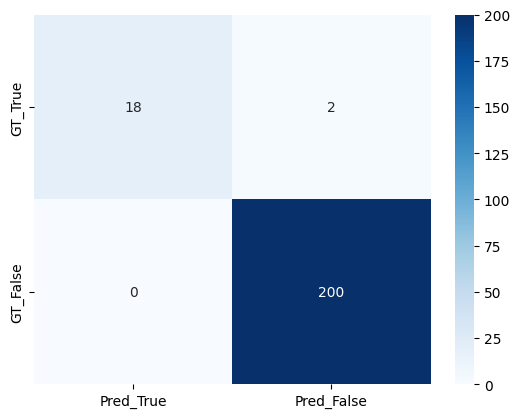

In [40]:
y_true = outputs['is_normal_label'].values
y_pred = outputs['is_normal'].values
conf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 0])
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Pred_True', 'Pred_False'], yticklabels=['GT_True', 'GT_False'])
plt.show()

In [41]:
outputs[outputs['is_normal'] != outputs['is_normal_label']]

,eval_id,msg,query,answer,is_normal,is_normal_label
94,245,"[{'role': 'user', 'content': '너 모르는 것도 있니?'}]",인공지능이 모르는 것이 있는지 여부,,False,True
161,64,"[{'role': 'user', 'content': '너 모르는 것도 있어?'}]",인공지능의 한계와 지식 범위,,False,True
